In [48]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.python.framework import ops
from time import time
from tensorflow import keras
from collections import deque
from tf2.Kfocusingtf2 import FocusedLayer1D
from scipy.integrate import trapz

# Plotting

In [37]:
def showTrend(scores, name=''):
    x = []
    y = []
    for i in range(0, len(scores)):
        x.append(int(i))
        y.append(int(scores[i]))

    plt.plot(x, y, label=name+" score per run")

    trend_x = x[1:]
    z = np.polyfit(np.array(trend_x), np.array(y[1:]), 1)
    p = np.poly1d(z)
    plt.plot(trend_x, p(trend_x), linestyle="-.",  label=name+" trend")


    plt.xlabel("episodes")
    plt.ylabel("scores")
    plt.legend(loc="upper left")

In [25]:
def statistic(scores, choices):
    meanByChoice = lambda lst, key: lst.count(key)/len(lst)

    print('Average Score: ',sum(scores)/len(scores))

    for i in set(choices):
        print(f"choice {i}:{meanByChoice(choices,i)}")

In [38]:
def lossComparison(name, results):
    plt.plot(results,  label=name+" loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('./graphs/'+nameFormat(name)+'_loss_grahp.png', bbox_inches="tight")
    plt.legend(loc="upper left")

In [5]:
nameFormat = lambda name:name+"-{}".format(int(time()))

# Neural Network Model

In [15]:
def build_model(N
                ,mode='dense'
                ,optimizer_s='adam'
                ,input_shape=None
                ,output_size=None):

    keras.backend.clear_session()

    if optimizer_s == 'SGDwithLR':
        pass #optimizer = SGDwithLR(lr_dict, mom_dict,decay_dict,clip_dict)
    elif optimizer_s == 'AdamwithCli':
        pass #optimizer = AdamwithClip()
    elif optimizer_s=='RMSpropwithClip':
        pass #optimizer = RMSpropwithClip(lr=0.001, rho=0.9, epsilon=None, decay=0.0,clips=clip_dict)
    elif optimizer_s=='adam':
        optimizer = keras.optimizers.Adam(lr=learning_rate)
    else:
        pass #optimizer = SGD(lr=0.01, momentum=0.9)
    

    if mode=='dense':
        layer = keras.layers.Dense(N[1], activation="elu")
    elif mode=='focused':
        layer = FocusedLayer1D(N[1], name='focus-1', activation='elu', init_sigma=0.25)

    model = keras.models.Sequential([
        keras.layers.Dense(N[0], activation="elu", input_shape=input_shape),
        layer,
        keras.layers.Dense(output_size)
    ])

    print(model.summary())

    return model, optimizer

# Creating Data and Test Run on Environment

In [97]:
class DQNAgent:
    def __init__(self
                 ,envName # the gym environment will run by agent
                 ,mode # the layer selection you may choice focused or dense
                 ,optimizer # optimizer selction will use on a model
                 ,seed=42 # random initializer
                 ,N=None): # each layers neuron count

        # initialize N with 32 neuron each count by default
        if N == None:
            N = [32,32]

        self.env = gym.make(envName)
        self.env.seed(seed)
        self.input_shape = self.env.observation_space.shape

        # Discretized DQNAgent action space
        self.is_discrete = type(self.env.action_space) == gym.spaces.discrete.Discrete
        if not self.is_discrete:
            shape = self.env.action_space.shape
            low = self.env.action_space.low
            high = self.env.action_space.high
            self.env.action_space.n = 10
            self.actions = np.linspace(low, high, 10, dtype="float32")
            print('The environment is not discrete')
            print('The action space: ', self.actions.reshape(1,-1)[0])
        
        self.output_size = self.env.action_space.n

        self.mode = mode
        
        self.replay_memory = deque(maxlen=2000)
        
        self.scores = []
        self.choices = []
        self.metrics = []
        self.best_score_index = 0
        self.best_score = 0
        self.score = 0
        
        self.epsilon = 0.95
        
        self.model, self.optimizer = build_model(N=N
                                                 ,mode=mode
                                                 ,optimizer_s=optimizer
                                                 ,input_shape=self.input_shape
                                                 ,output_size=self.output_size)
        
    def train(self):
        for episode in range(EPISODES):
            score = 0
            best_score_index = 0
            obs = self.env.reset()
            for step in range(ITERATIONS):
                self.epsilon = max(1 - episode / 500, 0.01)

                obs, reward, done, action = self.play_one_step(obs)

                score += reward

                if done:
                    break

            self.scores.append(score)

            if step > best_score_index:
                best_weights = self.model.get_weights()
                best_score_index = step

            print(f"\rEpisode: {episode+1}, Steps: {step+1}, eps: {self.epsilon}", end="")
            if episode > 50:
                lossValue= self.training_step()
                self.metrics.append(lossValue)

        # self.model.set_weights(best_weights)

    def play_one_step(self, state):
        state = self.setAxis(state)
        action = self.epsilon_greedy_policy(state)
        
        self.choices.append(action)
        
        next_state, reward, done, _ = self.env.step(self.get_action(action))

        self.replay_memory.append((state, action, self.isList(reward), self.setAxis(next_state), done))
        return next_state, reward, done, action

    def get_action(self, action):
        if not self.is_discrete:
            action = [self.actions[action]]
        return action

    def setAxis(self, state):
        if not self.is_discrete:
            state = state.reshape(1,-1)[0]
        return state
    
    def isList(self, obj):
        if type(obj) is list:
            return obj[0]
        return obj

    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.output_size)
        else:
            Q_values = self.model.predict(state[np.newaxis])

            return np.argmax(Q_values[0])
        
    def training_step(self):
        states, actions, rewards, next_states, dones = self.sample_experiences()

        next_Q_values = self.model.predict(next_states)
        max_next_Q_values = np.max(next_Q_values, axis=1)

        target_Q_values = (rewards +
                           (1 - dones) * discount_rate * max_next_Q_values)
        target_Q_values = target_Q_values.reshape(-1, 1)

        mask = tf.one_hot(actions, self.output_size)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        if self.mode=='focused':
            self.clipcallBack('Sigma', (0.05,1.0))
            self.clipcallBack('Mu', (0.0,1.0))

        return float(loss)
    
    def clipcallBack(self, varname, clips):
        all_weights = self.model.trainable_weights

        for i,p in enumerate(all_weights):
            # print(p.name)
            if (p.name.find(varname)>=0):
                pval = p.numpy()
                clipped = np.clip(pval,clips[0],clips[1])
                p.assign(clipped)
                # print("Clipped", p.name)
                
    def sample_experiences(self):
        indices = np.random.randint(len(self.replay_memory), size=batch_size)
        batch = [self.replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        return states, actions, rewards, next_states, dones

# Credentials

In [90]:
# random initializers
mpl.style.use('default')
gym.logger.set_level(40)
np.random.seed(42)
ops.reset_default_graph()
tf.random.set_seed(42)

# loss function initializer
loss_fn = keras.losses.mean_squared_error

#cridentals
mode = {'d':'dense'
        ,'f':'focused'}
optimizer_s = {'a':'adam'
              ,'sl':'SGDwithLR'
              ,'rc':'RMSpropwithClip'
              ,'ac':'AdamwithCli'}

EPISODES = 600 #how many episodes will run
ITERATIONS = 200 # how many steps will be taken by a episode
batch_size = 32 # sample size will driven to predict every episode
discount_rate = 0.95 # determines the importance of future rewards for q value
learning_rate = 1e-3 # determines to what extent newly acquired information overrides old information

# MountainCar section

In [91]:
envName = 'MountainCarContinuous-v0'
denseAgent = DQNAgent(N=[24,48]
                      ,envName=envName
                      ,mode=mode['d']
                      ,optimizer=optimizer_s['a'])

The environment is not discrete
The action space:  [-1.         -0.7777778  -0.5555556  -0.3333333  -0.1111111   0.11111116
  0.33333337  0.5555556   0.7777778   1.        ]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                72        
_________________________________________________________________
dense (Dense)                (None, 48)                1200      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                490       
Total params: 1,762
Trainable params: 1,762
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
focusedAgent = DQNAgent(N=[24,48]
                        ,envName=envName
                        ,mode=mode['f']
                        ,optimizer=optimizer_s['a'])

The environment is not discrete
The action space:  [-1.         -0.7777778  -0.5555556  -0.3333333  -0.1111111   0.11111116
  0.33333337  0.5555556   0.7777778   1.        ]
{'name': 'focus-1'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                72        
_________________________________________________________________
focus-1 (FocusedLayer1D)     (None, 48)                1296      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
Total params: 1,858
Trainable params: 1,858
Non-trainable params: 0
_________________________________________________________________
None


In [93]:
denseAgent.train()

Episode: 67, Steps: 200, eps: 0.868WARNING:tensorflow:Layer dense_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 600, Steps: 200, eps: 0.010000000000000009

In [94]:
focusedAgent.train()

Episode: 54, Steps: 200, eps: 0.894WARNING:tensorflow:Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 600, Steps: 200, eps: 0.010000000000000009

Area Under Dense Curve -2153.5062828153145
Average Score:  -3.596378784501526
choice 0:0.04115833333333333
choice 1:0.04158333333333333
choice 2:0.04135
choice 3:0.059925
choice 4:0.22600833333333334
choice 5:0.417425
choice 6:0.04538333333333333
choice 7:0.042758333333333336
choice 8:0.04178333333333333
choice 9:0.042625
Area Under Focused Curve -2154.232221089558
Average Score:  -3.597053702185704
choice 0:0.041425
choice 1:0.042216666666666666
choice 2:0.042508333333333335
choice 3:0.052816666666666665
choice 4:0.18566666666666667
choice 5:0.44648333333333334
choice 6:0.06416666666666666
choice 7:0.042083333333333334
choice 8:0.04215833333333333
choice 9:0.040475


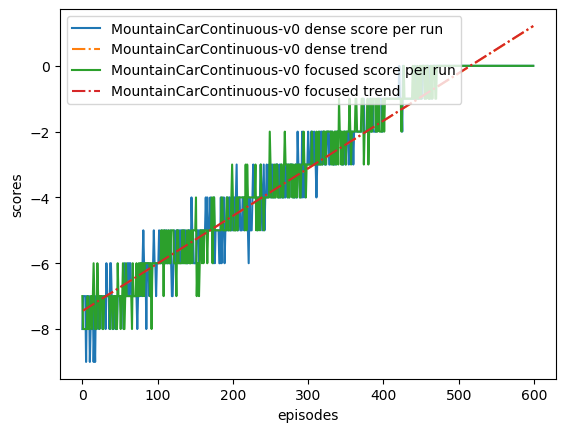

In [95]:
print('Area Under Dense Curve',trapz(denseAgent.scores))

statistic(scores=denseAgent.scores
          ,choices=denseAgent.choices)

print('Area Under Focused Curve',trapz(focusedAgent.scores))
statistic(scores=focusedAgent.scores
          ,choices=focusedAgent.choices)

plt.figure(figsize=(20, 15))
# dense results
showTrend(scores=denseAgent.scores, name=envName + " dense")
# focused results
showTrend(scores=focusedAgent.scores, name=envName + " focused")

Area of Dense:  0.19976746819307367
Area of Focused:  0.39599734331584013


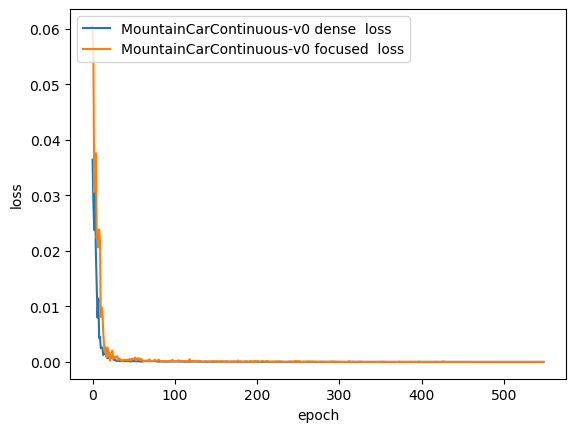

In [96]:
plt.figure(figsize=(20, 15))
lossComparison(results=denseAgent.metrics
               ,name=envName + " dense ")
lossComparison(results=focusedAgent.metrics
               ,name=envName + " focused ")
print('Area of Dense: ',trapz(denseAgent.metrics))
print('Area of Focused: ',trapz(focusedAgent.metrics))
# In this graph, more smaller area size means decisions are more accurate

# CartPole section

In [13]:
envName = 'CartPole-v1'
denseAgent = DQNAgent(envName=envName
                     ,mode=mode['d']
                     ,optimizer=optimizer_s['a'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
focusedAgent = DQNAgent(envName=envName
                         ,mode=mode['f']
                         ,optimizer=optimizer_s['a'])

{'name': 'focus-1'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
focus-1 (FocusedLayer1D)     (None, 32)                1120      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,346
Trainable params: 1,346
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
denseAgent.train()

Episode: 52, Steps: 42, eps: 0.8989999999999999WARNING:tensorflow:Layer dense_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 600, Steps: 19, eps: 0.011000000000000009

In [19]:
focusedAgent.train()

Episode: 52, Steps: 15, eps: 0.8989999999999999WARNING:tensorflow:Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 600, Steps: 62, eps: 0.011000000000000009

Area Under Dense Curve 13340.0
Average Score:  22.298333333333332
choice 0:0.4826967635847223
choice 1:0.5173032364152776
Area Under Focused Curve 16966.5
Average Score:  28.338333333333335
choice 0:0.4685055578427336
choice 1:0.5314944421572664


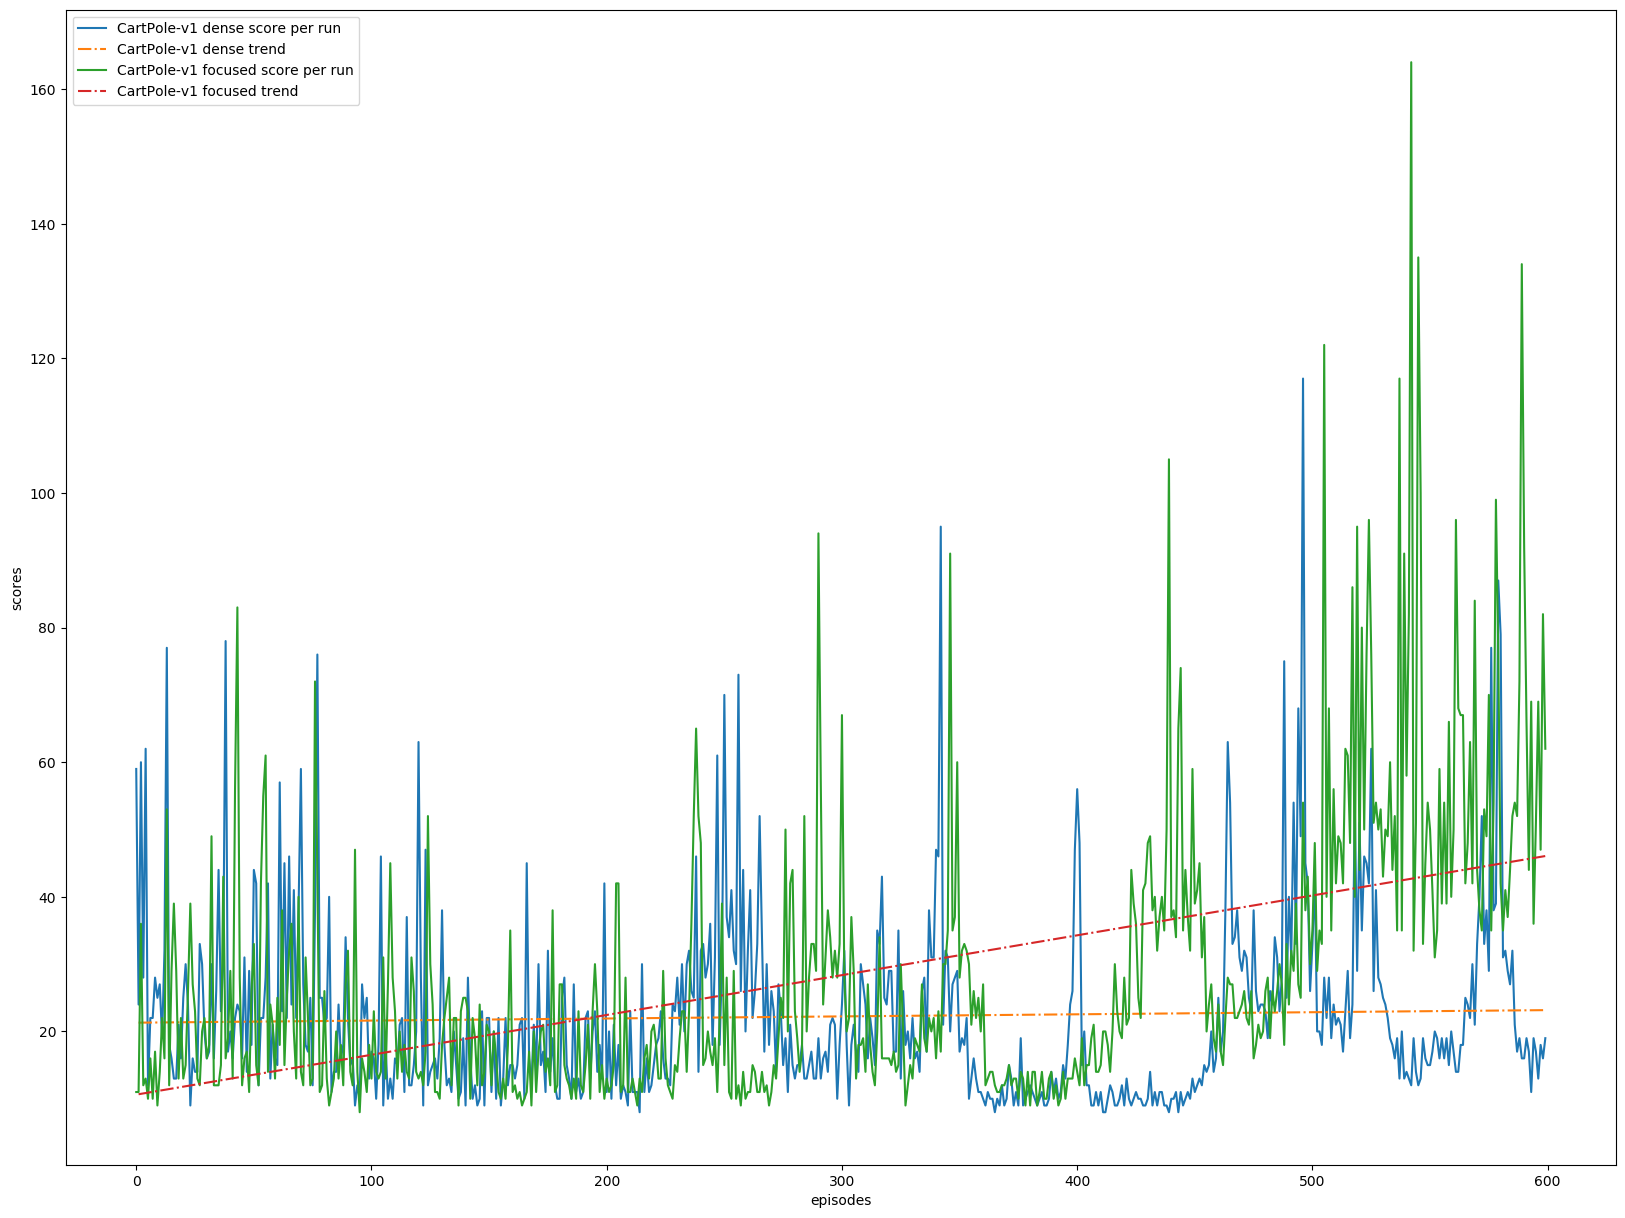

In [50]:
print('Area Under Dense Curve',trapz(denseAgent.scores))

statistic(scores=denseAgent.scores
          ,choices=denseAgent.choices)

print('Area Under Focused Curve',trapz(focusedAgent.scores))
statistic(scores=focusedAgent.scores
          ,choices=focusedAgent.choices)

plt.figure(figsize=(20, 15))
# dense results
showTrend(scores=denseAgent.scores, name=envName + " dense")
# focused results
showTrend(scores=focusedAgent.scores, name=envName + " focused")

Area of Dense:  2555.847782164812
Area of Focused:  2003.7387240044773


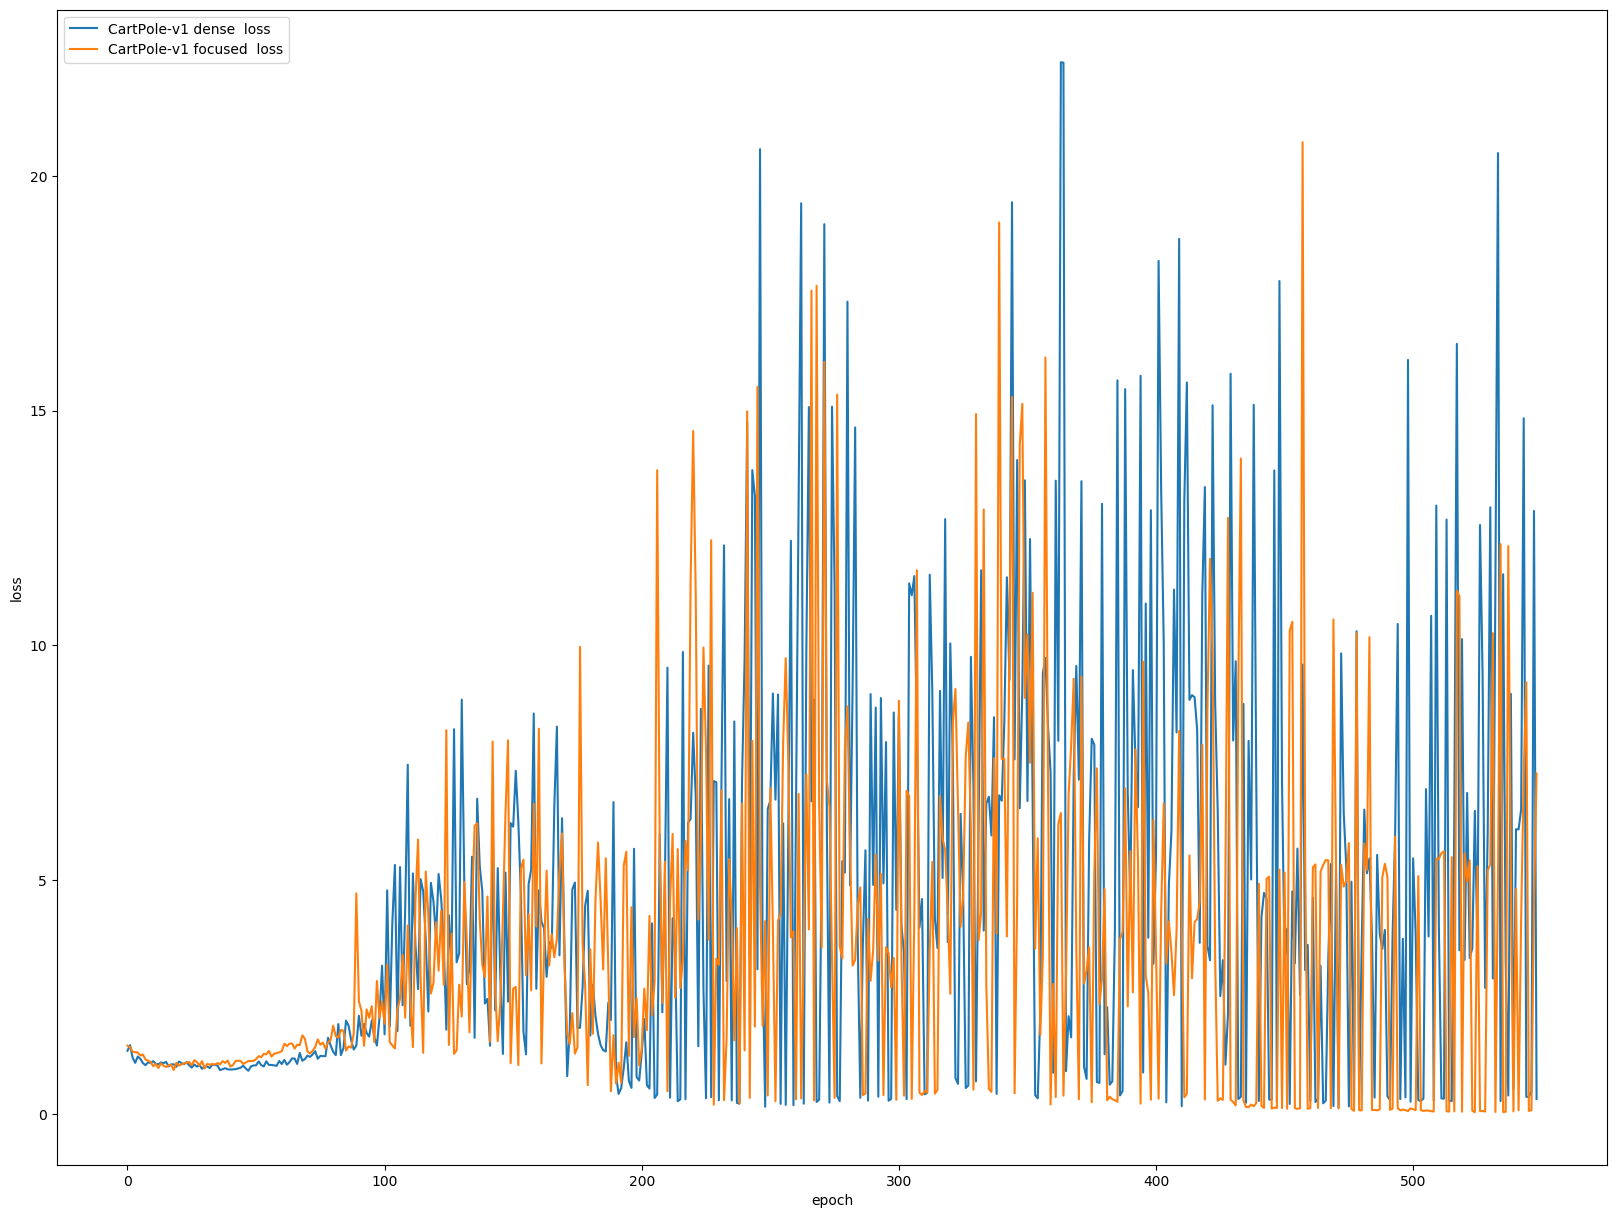

In [51]:
plt.figure(figsize=(20, 15))
lossComparison(results=denseAgent.metrics
               ,name=envName + " dense ")
lossComparison(results=focusedAgent.metrics
               ,name=envName + " focused ")
print('Area of Dense: ',trapz(denseAgent.metrics))
print('Area of Focused: ',trapz(focusedAgent.metrics))
# In this graph, more smaller area size means decisions are more accurate

# Acrobot Section

In [98]:
envName='Acrobot-v1'
denseAgent = DQNAgent(envName=envName
                     ,mode=mode['d']
                     ,optimizer=optimizer_s['a'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
focusedAgent = DQNAgent(envName=envName
                         ,mode=mode['f']
                         ,optimizer=optimizer_s['a'])

{'name': 'focus-1'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
focus-1 (FocusedLayer1D)     (None, 32)                1120      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,443
Trainable params: 1,443
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
denseAgent.train()

Episode: 52, Steps: 200, eps: 0.898WARNING:tensorflow:Layer dense_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 91, Steps: 200, eps: 0.8200000000000001

In [ ]:
focusedAgent.train()

In [ ]:
print('Area Under Dense Curve',trapz(denseAgent.scores))

statistic(scores=denseAgent.scores
          ,choices=denseAgent.choices)

print('Area Under Focused Curve',trapz(focusedAgent.scores))
statistic(scores=focusedAgent.scores
          ,choices=focusedAgent.choices)

plt.figure(figsize=(20, 15))
# dense results
showTrend(scores=denseAgent.scores, name=envName + " dense")
# focused results
showTrend(scores=focusedAgent.scores, name=envName + " focused")

In [ ]:
plt.figure(figsize=(20, 15))
lossComparison(results=denseAgent.metrics
               ,name=envName + " dense ")
lossComparison(results=focusedAgent.metrics
               ,name=envName + " focused ")
print('Area of Dense: ',trapz(denseAgent.metrics))
print('Area of Focused: ',trapz(focusedAgent.metrics))
# In this graph, more smaller area size means decisions are more accurate

# Model Test With Other Environments

# Pendulum
    - it tries to hold a stick in balance after 180 degree rotation
    - observation space: cos(theta), sin(theta), theta dot product
    - action space is continuous: -2, 2
    - reward is similar with acrobot: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) 

In [ ]:
envName='Pendulum-v0'
denseAgent = DQNAgent(envName=envName
                     ,mode=mode['d']
                     ,optimizer=optimizer_s['a'])

In [ ]:
focusedAgent = DQNAgent(envName=envName
                         ,mode=mode['f']
                         ,optimizer=optimizer_s['a'])

In [ ]:
denseAgent.train()

In [ ]:
focusedAgent.train()

In [ ]:
print('Area Under Dense Curve',trapz(denseAgent.scores))

statistic(scores=denseAgent.scores
          ,choices=denseAgent.choices)

print('Area Under Focused Curve',trapz(focusedAgent.scores))
statistic(scores=focusedAgent.scores
          ,choices=focusedAgent.choices)

plt.figure(figsize=(20, 15))
# dense results
showTrend(scores=denseAgent.scores, name=envName + " dense")
# focused results
showTrend(scores=focusedAgent.scores, name=envName + " focused")

In [ ]:
plt.figure(figsize=(20, 15))
lossComparison(results=denseAgent.metrics
               ,name=envName + " dense ")
lossComparison(results=focusedAgent.metrics
               ,name=envName + " focused ")
print('Area of Dense: ',trapz(denseAgent.metrics))
print('Area of Focused: ',trapz(focusedAgent.metrics))
# In this graph, more smaller area size means decisions are more accurate